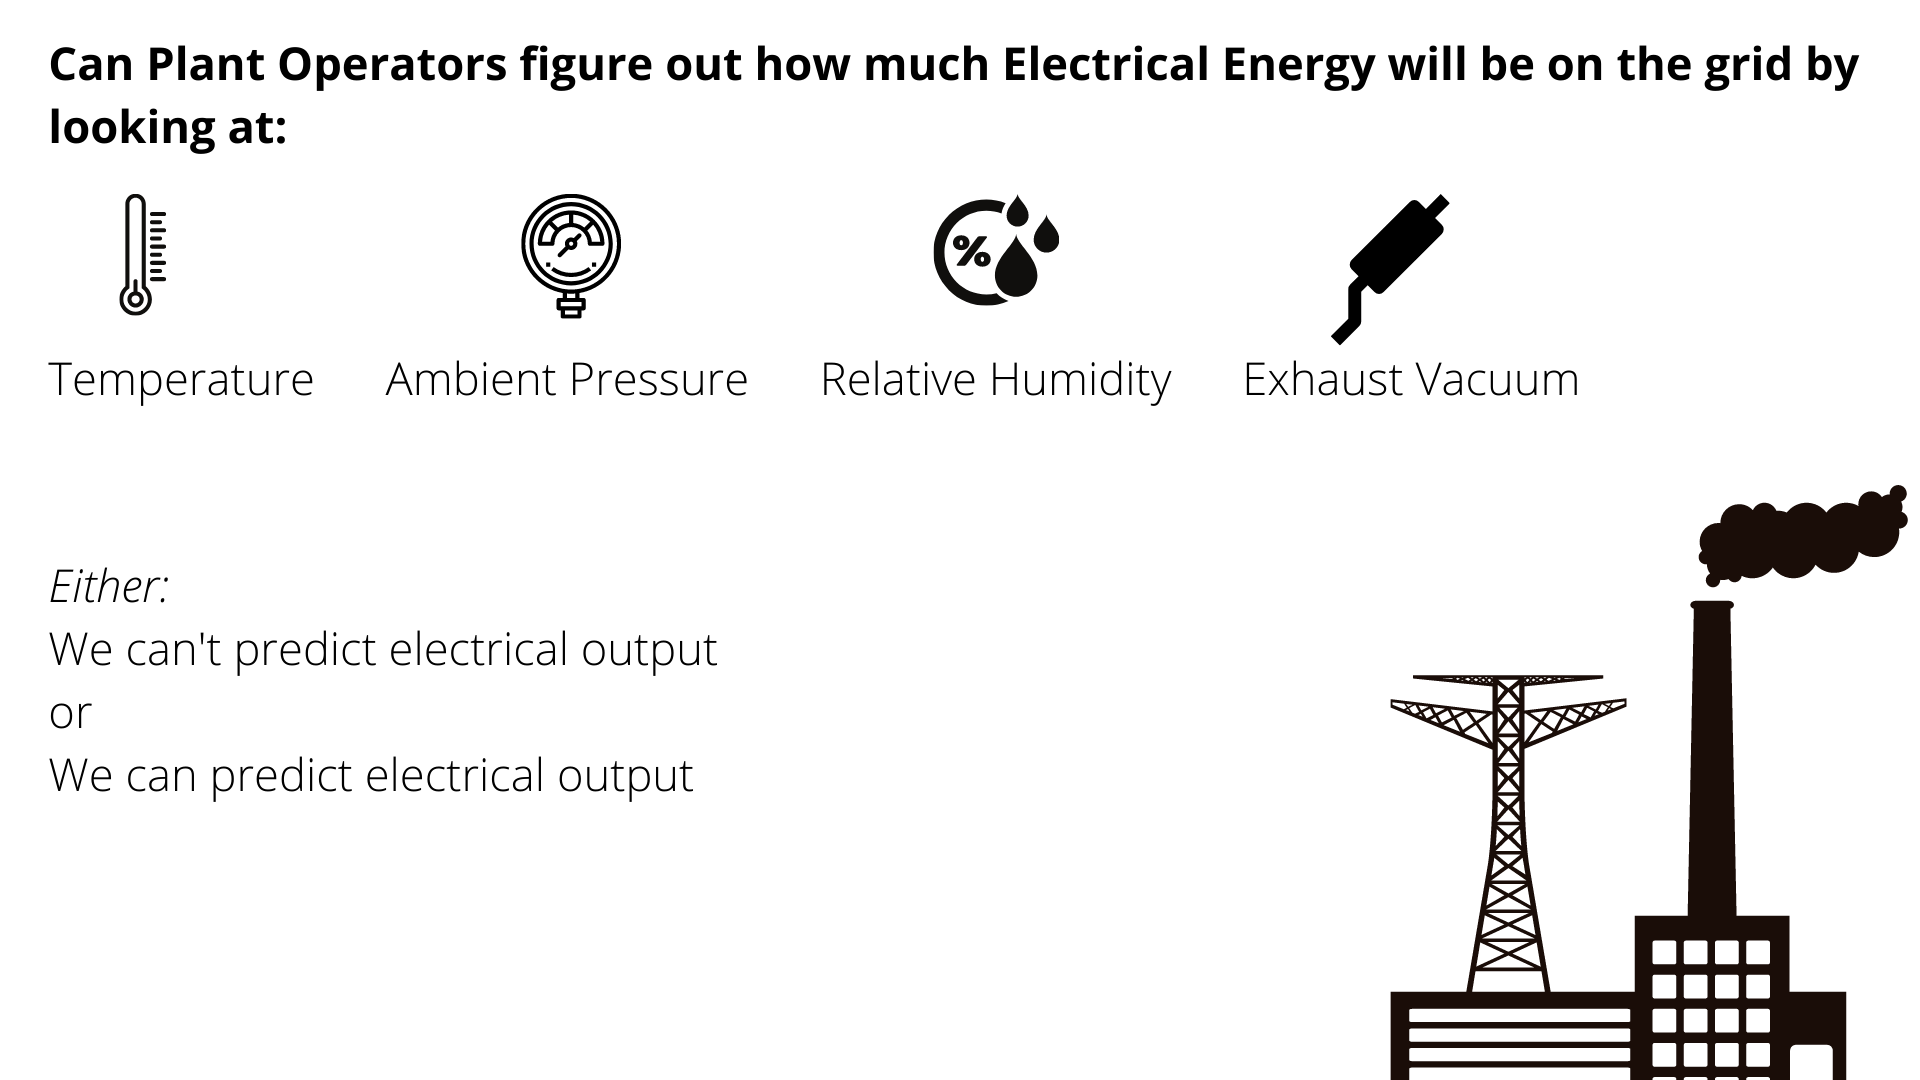

# **Problem Statement and Hypothesis**

**Problem Statement**

Precise estimates of electric power output are critical for energy profitability. Can a regression model of Combined Cycle Power Plant electric energy output be constructed based solely on the Folds5x2_pp dataset? 


**Hypothesis**

H0: A predictive regression model cannot be constructed from the Folds5x2_pp dataset. 

H1: A predictive regression model can be constructed from the Folds5x2_pp dataset. 

A predictive model could be built using the mean value of electrical output without factoring input features. This model would completely abandon predicting variability in electrical output. This project considers a model 'can be constructed’ if its R2 score explains at least 0.95 of the variances in the data and if the Root Mean Squared Error (RSME) is less than five. 


The Folds5x2_pp dataset was collected from a Combined Cycle Power Plant between 2006-2011. This dataset is publicly available through the UCI Machine Learning Repository. There are four input features in this dataset: Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). These inputs will be used to predict an output of net hourly electrical energy (PE). The dataset contains 9568 data points.

EDA

In [ ]:
!pip install -q shap
import shap
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import anderson
import matplotlib.pyplot as plt
import pylab
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_excel('Folds5x2_pp.xlsx', sheet_name='Sheet1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


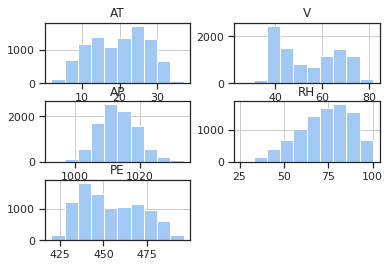

In [ ]:
df.hist()
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = df[['AT','V','AP', 'RH']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif.sort_values(by=['VIF'], ascending=False)

,VIF,features
1,74.969127,V
2,66.618618,AP
3,40.704756,RH
0,39.157705,AT


Multicollinearity is found in the data. Removing features will reduce the VIF of the remaining features.

In [ ]:
newdf = df.copy()

newdf.drop('V',axis=1, inplace=True)
newdf.drop('AP',axis=1, inplace=True)

In [ ]:
variables = newdf[['AT','RH']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif.sort_values(by=['VIF'], ascending=False)

,VIF,features
1,4.413538,RH
0,4.413538,AT


Check for outliers

In [ ]:
def outlierData(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

In [ ]:
lower, upper = outlierData(df['PE'])
print(lower)
print(upper)
print(df['PE'].where(df['PE'] > upper).value_counts().sum())
print(df['PE'].where(df['PE'] < lower).value_counts().sum())

396.73
511.45000000000005
0
0


In [ ]:
lower, upper = outlierData(df['V'])
print(lower)
print(upper)
print(df['V'].where(df['V'] > upper).value_counts().sum())
print(df['V'].where(df['V'] < lower).value_counts().sum())

4.539999999999999
103.74000000000001
0
0


In [ ]:
lower, upper = outlierData(df['AP'])
print(lower)
print(upper)
print(df['AP'].where(df['AP'] > upper).value_counts().sum())
print(df['AP'].where(df['AP'] < lower).value_counts().sum())

996.8600000000001
1029.5
73
15


In [ ]:
lower, upper = outlierData(df['RH'])
print(lower)
print(upper)
print(df['RH'].where(df['RH'] > upper).value_counts().sum())
print(df['RH'].where(df['RH'] < lower).value_counts().sum())

31.073750000000004
117.08375
0
12


In [ ]:
lower, upper = outlierData(df['AT'])
print(lower)
print(upper)
print(df['AT'].where(df['AT'] > upper).value_counts().sum())
print(df['AT'].where(df['AT'] < lower).value_counts().sum())

-4.804999999999998
44.035
0
0


OLS

In [ ]:
y = df['PE']
X1 = df.drop('PE',axis=1)
x = sm.add_constant(X1)
reg = sm.OLS(y, x)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        14:30:48   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

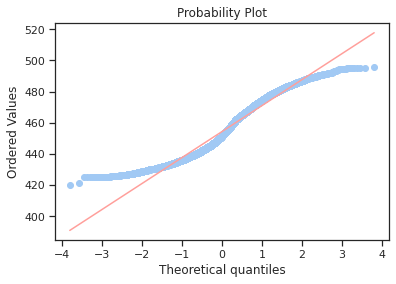

In [ ]:
#Fat tail qq plot
stats.probplot(df['PE'], dist='norm', plot=pylab)
pylab.show()

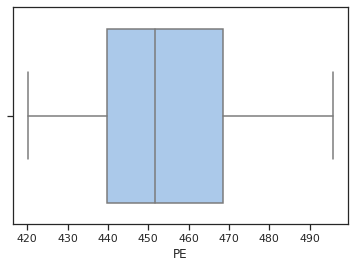

In [ ]:
sns.boxplot(x=df["PE"])

In [ ]:
anderson(df['PE'])

AndersonResult(statistic=137.7106820852132, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

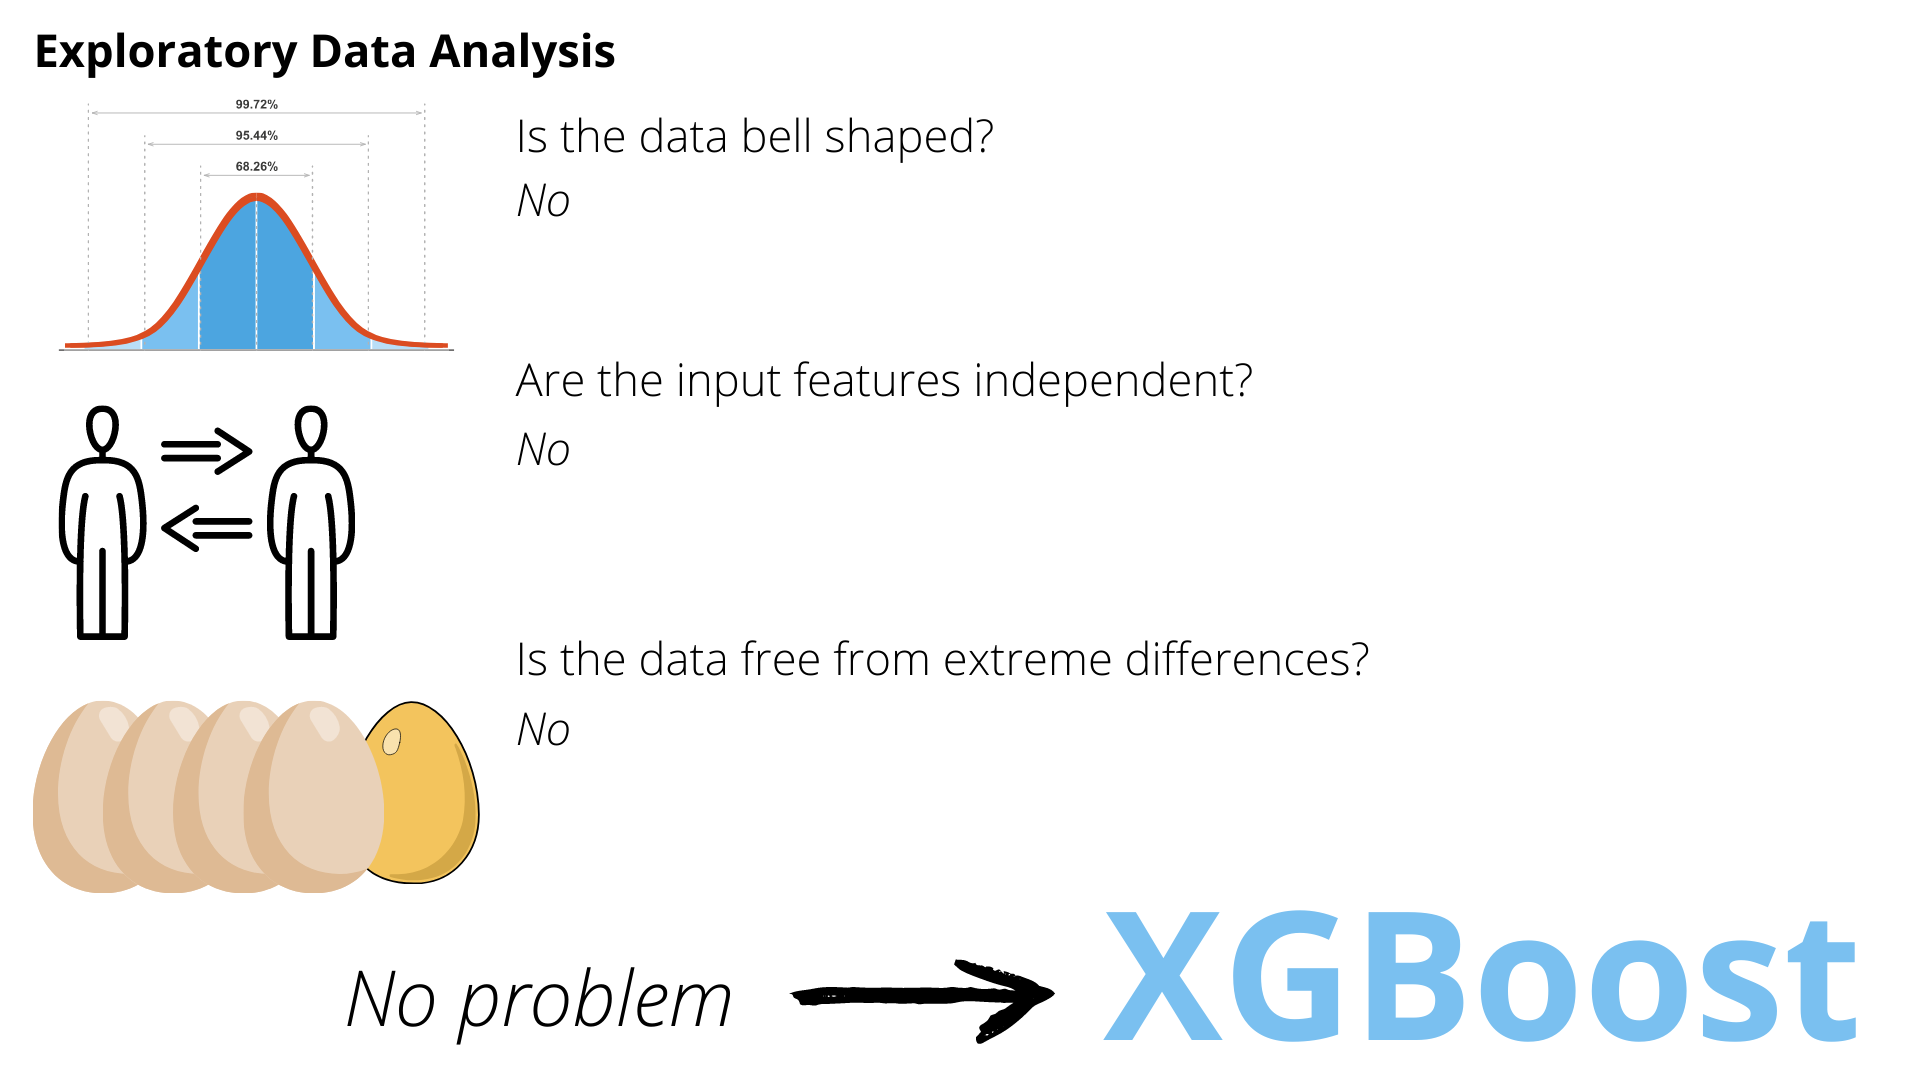

Exploratory analysis reveals a non-normal distribution, multicollinearity, and the presence of outliers. Strategies to mitigate these artifacts have been eschewed because XGBoost (the model used in this study) performs well on nonlinear relationships and is resilient against outliers. The default objective function was used to train the model. A low max_depth (the default value is 6) and a low early_stopping_rounds value were also included in the model parameters to prevent overfitting. num_boost_round was set to a value of rounds large enough to tune feature weights from prior residual errors but not so large as to slow the performance of the model.

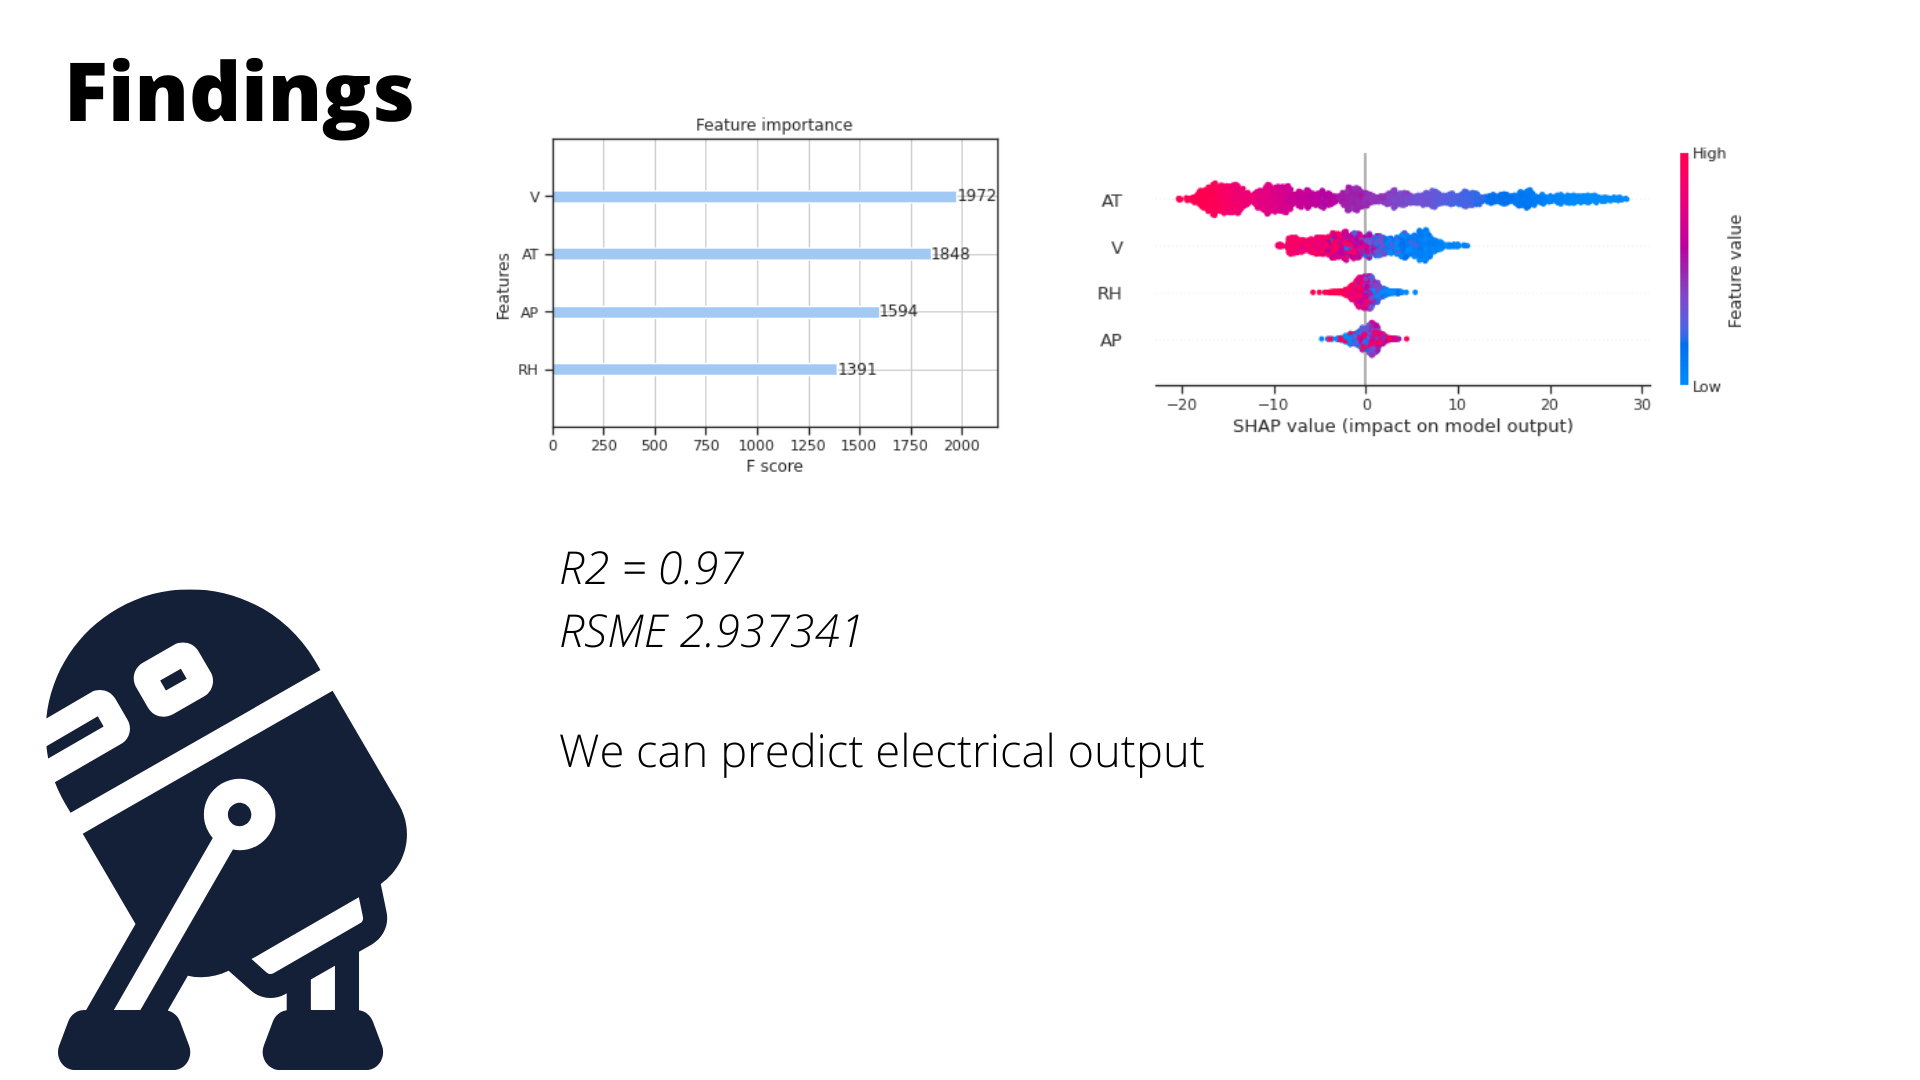

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test= train_test_split(X1, y,test_size=0.2, random_state=42)


Feature importance of independent variables

In [ ]:
ccp_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = {'objective': 'reg:squarederror', 'max_depth':4, 'early_stopping_rounds': 5}
xg_reg = xgb.train(params=params, dtrain= ccp_dmatrix, num_boost_round=500)


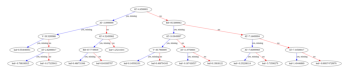

In [ ]:
xgb.plot_tree(xg_reg, num_trees=19, rank='LR')
plt.show()

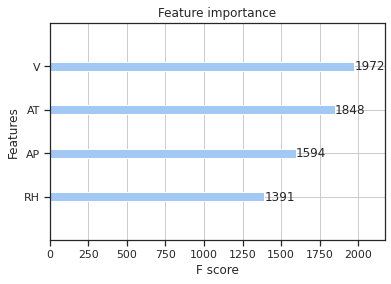

In [ ]:
xgb.plot_importance(xg_reg)
plt.show()

Test Accuracy

In [ ]:
ccp_test = xgb.DMatrix(data=X_test, label=y_test)
preds = xg_reg.predict(ccp_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse)) 
print("R2: %f" % r2_score(y_test, preds))

RMSE: 2.937341
R2: 0.970254


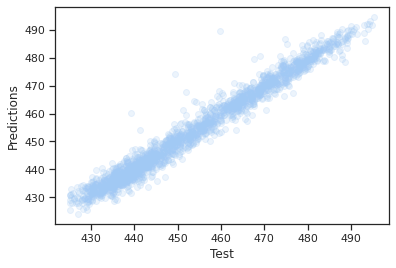

In [ ]:
plt.scatter(y_test, preds, alpha=0.2)
plt.xlabel('Test')
plt.ylabel('Predictions')
plt.show()

Explaination

In [ ]:
cols = df.drop('PE', axis=1).columns.values.tolist()
explain = shap.TreeExplainer(xg_reg)
shap_v = explain.shap_values(X_test)

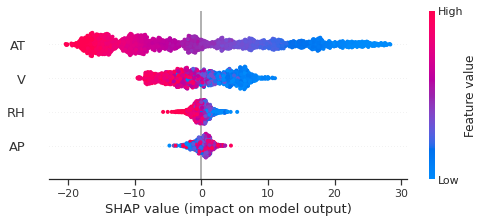

In [ ]:
shap.initjs() 
shap.summary_plot(shap_v, X_test, feature_names = cols)

Exhaust Vacuum was the most important feature and appeared the model’s tree 1,972 times out of 2,000 boosted training rounds.  Relative Humidity showed 1,391 times and appeared the least frequently of the four features. SHAP (SHapley Additive exPlanations)  analysis on test data shows Relative Humidity and Ambient Pressure have short ranges of influence and cluster around having no impact on the model’s output. The low contributions of Relative Humidity and Ambient Pressure on the test data match the expectation of feature importance shown in the training data. 

The test data RSME (2.937341) and R2 (0.97) scores meet the minimum criteria to accept the alternate hypothesis that a model can be constructed.


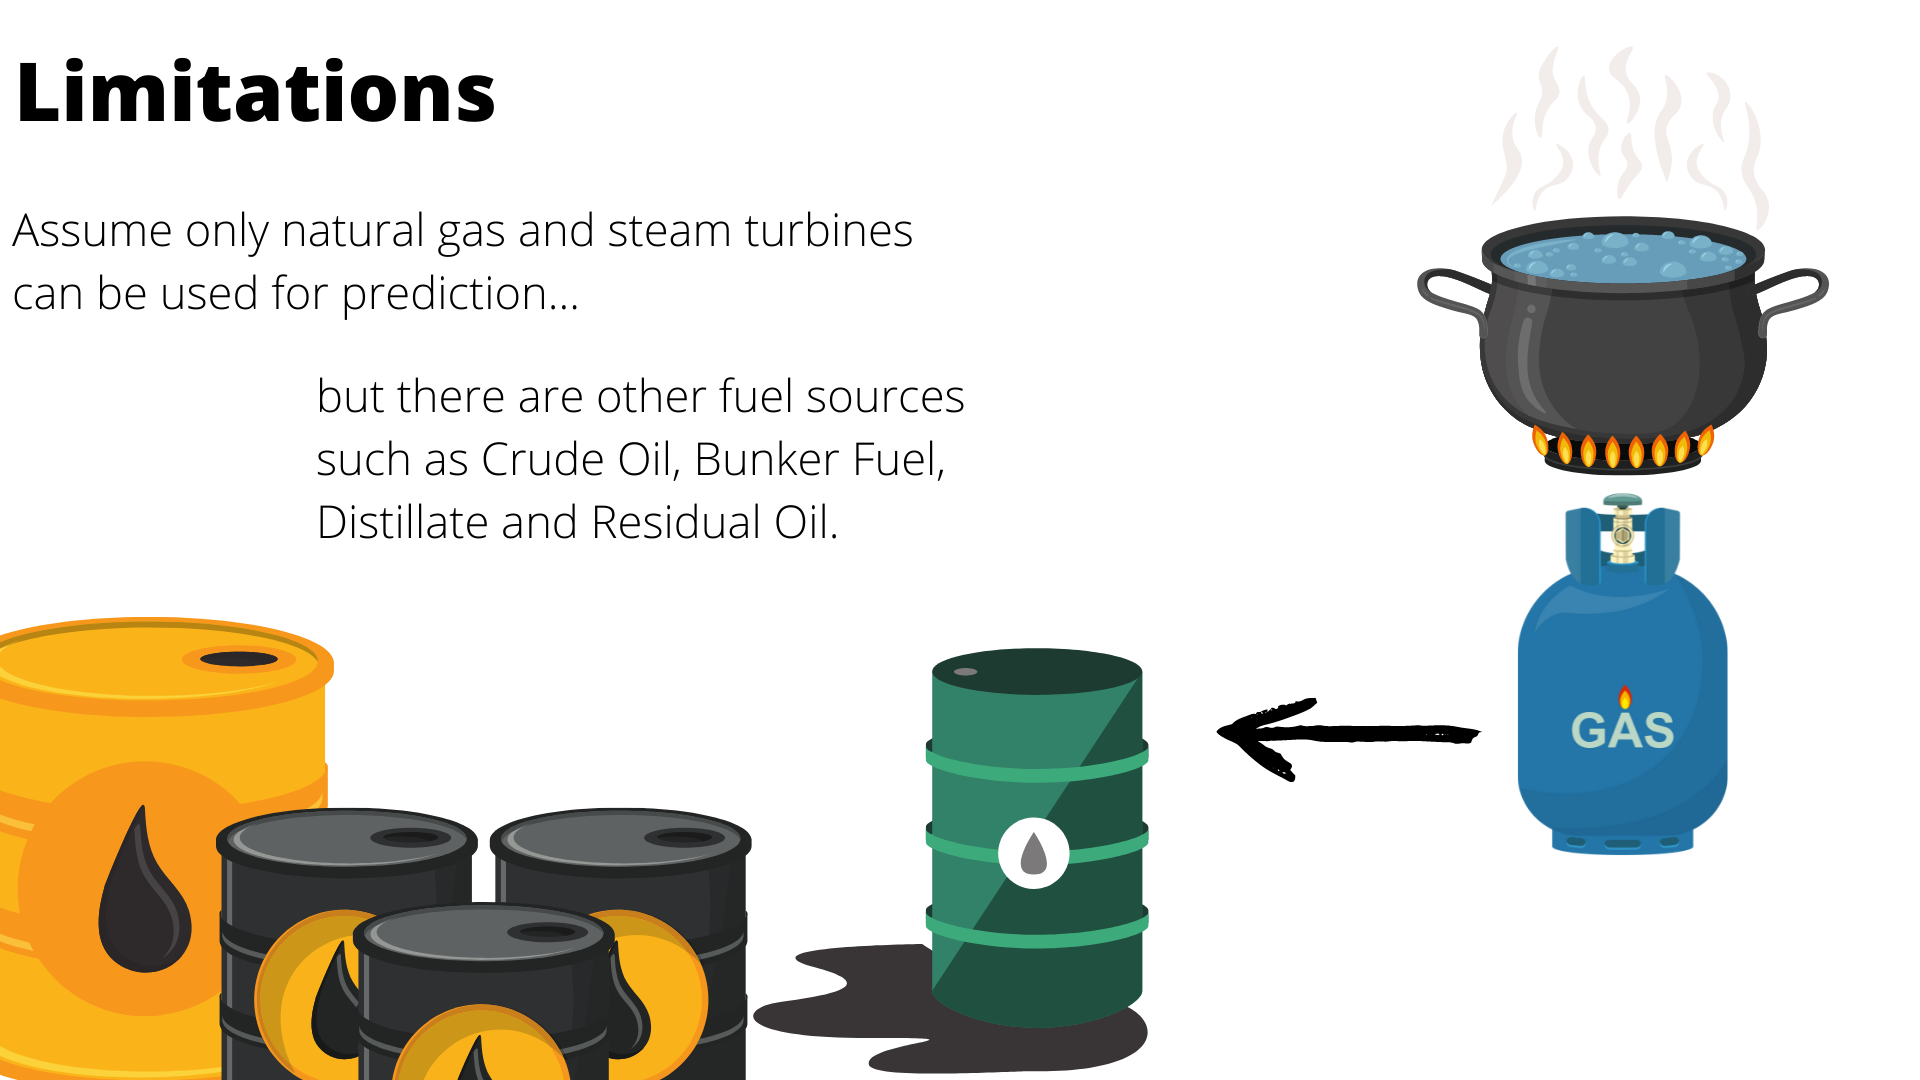

Using external data sacrifices control over the collection process. The Readme file of the dataset repository assumes that a Combined Cycle Power Plant is comprised of gas turbines. This is a fallacious generalization since Crude Oil, Bunker Fuel, Distillate and Residual Oil can also be used. If this dataset only recorded Natural Gas, the resulting predictions may fail to generalize on Power Plants with other fuel sources.

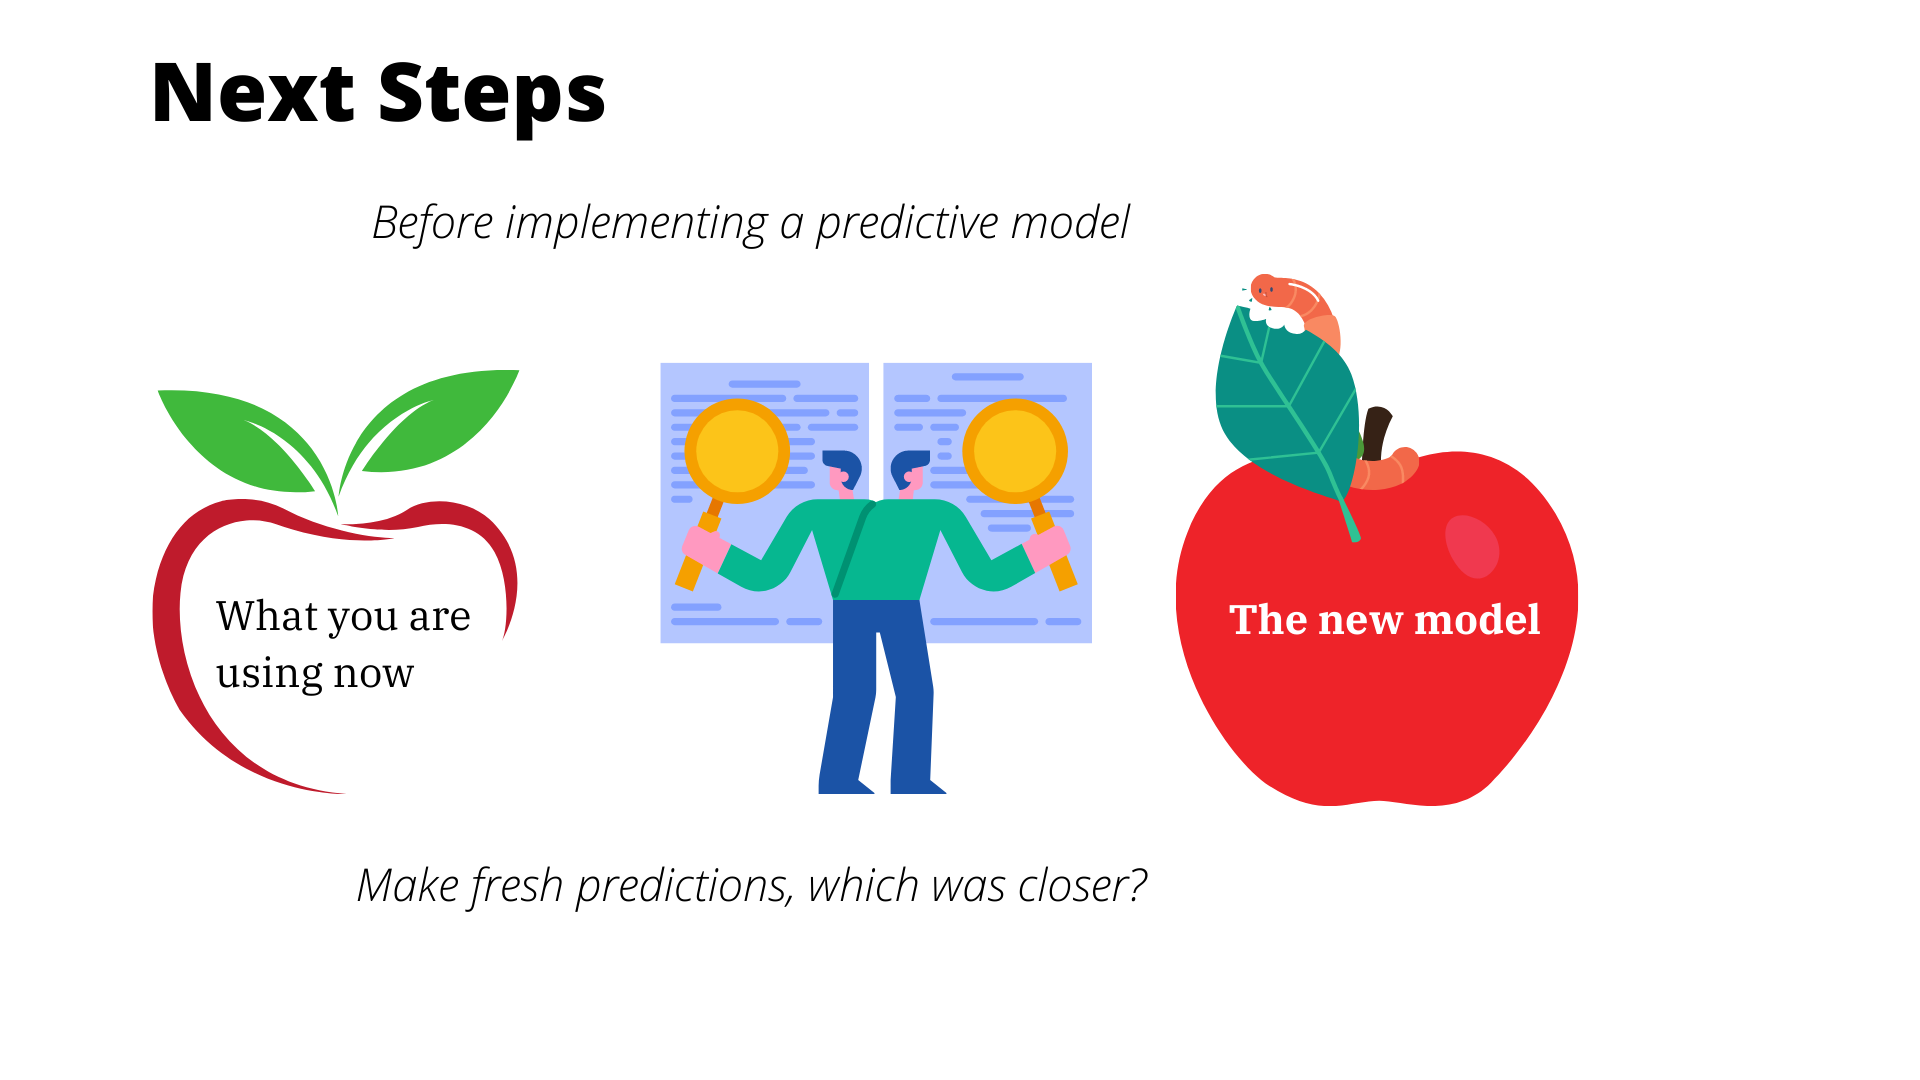

Assuming that input collection is not cost prohibitive, it is the recommendation of this analysis to save and load the model for future predictions but withhold from implementation into production calculations. Plant operators will have existing methodology in place to predict energy on the grid. If new predictions outperform existing methodology (and held to statistical rigor that this difference is unlikely due to chance) then the next phase of planning for the model to roll out into a production environment can commence.